# Cat Dog Classification

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as transforms  # Import the updated torchvision transforms (version 2)
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

We will create two datasets. One is unbalanced (when our dataset is balanced) for testing and validation. The other is balanced for training (here we have a different amount of data in two classes, so we need to balance it via a dataset).

First dataset is unbalanced. It is enough to give a path to images and it will load them and decide on their labels.

In [2]:
class ImageAugmentationDatasetUnbalanced(Dataset):
    """
    A custom PyTorch Dataset class that loads images from a directory,
    applies a series of augmentations to each image, and returns the augmented images and their labels.
    This class is designed to simulate an infinite dataset by wrapping around the dataset indices.
    """

    def __init__(self, image_dir, image_size=(128, 128), is_training=True):
        """
        Initializes the dataset by listing all image files in the specified directory
        and assigning labels based on the filename.

        Args:
            image_dir (str): The directory containing the image files.
            image_size (tuple): The desired output size of the images (width, height).
        """
        self.image_dir = image_dir  # Store the path to the image directory
        self.image_size = image_size  # Store the desired image size
        self.is_training = is_training

        # List comprehension to gather all image files with specified extensions
        self.image_files = [
            f for f in os.listdir(image_dir)
            if f.endswith(('.png', '.jpg', '.jpeg'))
        ]
        # Now, self.image_files contains all the image filenames in the directory

        # Assign labels based on the first character of the filename
        # 1 for "cats" (capital letter), 0 for "dogs" (small letter)
        self.labels = [
            1 if f[0].isupper() else 0 for f in self.image_files
        ]

    def __len__(self):
        """
        Returns the total number of images in the dataset.

        Returns:
            int: The number of image files found in the directory.
        """
        return len(self.image_files)  # Return the total count of image files

    def augment(self, image):
        """
        Applies a sequence of augmentation transforms to the input image.

        Args:
            image (PIL.Image.Image): The input image to be augmented.

        Returns:
            torch.Tensor: The augmented image as a tensor.
        """
        # Calculate the minimum size for resizing to ensure the image is large enough after cropping
        min_size = max(self.image_size) + 40  # Add padding (40 pixels) to the largest dimension

        # Normalization (commented out if not needed)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        
        # Compose a sequence of augmentation transforms
        aug_transforms = transforms.Compose([
            transforms.Resize((min_size, min_size)),  # Resize the image to at least min_size
            transforms.RandomCrop(size=self.image_size),  # Randomly crop to the desired size
            #transforms.RandomVerticalFlip(),  # Randomly flip the image vertically (Up/Down) with a 50% chance (disabled as we do not expect upsidedown images)
            transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally (Left/Right) with a 50% chance
            transforms.ColorJitter(
                brightness=0.2,  # Adjust brightness by a factor of ±0.5
                contrast=0.2     # Adjust contrast by a factor of ±0.5
            ),
            transforms.RandomAffine(
                degrees=10,              # Rotate the image randomly within ±10 degrees
                scale=(0.7, 1.3),        # Randomly scale the image
                translate=(0.1, 0.1)     # Translate the image randomly by up to 10% in both directions
            ),
            
            transforms.ToImage(),  # Ensure the output is a PIL Image
            transforms.ToDtype(torch.float32, scale=True),  # Convert to float32 tensor and scale pixel values to [0, 1]
            normalize, # Normalize by subtracting mean and dividing by std. deviation (expect negative and positive values)
        ])

        # Transforms for evaluation mode
        out_transforms = transforms.Compose([
            transforms.Resize(self.image_size),  # Resize to the desired size
            transforms.ToImage(),  # Ensure the output is a PIL Image
            transforms.ToDtype(torch.float32, scale=True),  # Convert to float32 tensor and scale pixel values to [0, 1]
            normalize, # Normalize by subtracting mean and dividing by std. deviation (expect negative and positive values)
        ])

        # Apply the composed transforms to the image
        if self.is_training:
            augmented_image = aug_transforms(image)
            return augmented_image  # Return the augmented image tensor
        else:
            output_image = out_transforms(image)
            return output_image  # Return the processed image tensor

    def __getitem__(self, idx):
        """
        Retrieves an augmented image and its label based on the given index.

        Args:
            idx (int): The index of the image to retrieve.

        Returns:
            tuple: A tuple containing the augmented image tensor and its label.
        """
        # Wrap around the dataset indices using modulo to handle infinite indices
        real_idx = idx % len(self.image_files)
        # Construct the full path to the image file
        img_path = os.path.join(self.image_dir, self.image_files[real_idx])
        # Open the image and convert it to RGB mode to ensure consistency
        image = Image.open(img_path).convert('RGB')
        # Apply augmentations to the image
        augmented_image = self.augment(image)
        # Retrieve the label for the current image
        label = self.labels[real_idx]
        return augmented_image, label  # Return the augmented image and its label

Another dataset is balanced. For it we need to supply two lists with paths to images for each class. This dataset will alternate between supplied lists and read files. When the shorter list is empty, it will start over that list.

In [3]:
class ImageAugmentationDatasetBalanced(Dataset):
    """
    A custom PyTorch Dataset class that loads images from a given lists,
    applies a series of augmentations to each image, and returns the augmented images and their labels.
    This class ensures class balancing between 'cats' and 'dogs' by alternating between classes
    (even indices return one class, odd indices return the other).
    """
    
    def __init__(self, class0_files, class1_files, image_size=(128, 128), is_training=True):
        """
        Initializes the dataset by listing all image files in the specified directory,
        assigning labels based on the filename, and separating the images into two classes.

        Args:
            class0_files (list): List containing the image files for class0.
            class1_files (list): List containing the image files for class1.
            image_size (tuple): The desired output size of the images (width, height).
            is_training (bool): Switch on augmentation of dataset if True.
        """
        
        self.image_size = image_size  # Store the desired image size
        self.is_training = is_training  # Flag indicating training or evaluation mode

        # Initialize lists to store filenames for each class
        self.class0_files = class0_files  # Class 0 (e.g., dogs)
        self.class1_files = class1_files  # Class 1 (e.g., cats)

        # Store the lengths of each class list for later use
        self.len_class0 = len(self.class0_files)
        self.len_class1 = len(self.class1_files)

    def __len__(self):
        """
        If returns a number of max(samples one class, samples other class) * 2

        Returns:
            int: A number representing the dataset length.
        """
        return max(self.len_class0, self.len_class1) * 2

    def augment(self, image):
        """
        Applies a sequence of augmentation transforms to the input image.

        Args:
            image (PIL.Image.Image): The input image to be augmented.

        Returns:
            torch.Tensor: The augmented image as a tensor.
        """
        # Calculate the minimum size for resizing to ensure the image is large enough after cropping
        min_size = max(self.image_size) + 40  # Add padding (40 pixels) to the largest dimension

        # Normalization (commented out if not needed)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        
        # Compose a sequence of augmentation transforms
        aug_transforms = transforms.Compose([
            transforms.Resize((min_size, min_size)),  # Resize the image to at least min_size
            transforms.RandomCrop(size=self.image_size),  # Randomly crop to the desired size
            #transforms.RandomVerticalFlip(),  # Randomly flip the image vertically (Up/Down) with a 50% chance (disabled as we do not expect upsidedown images)
            transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally (Left/Right) with a 50% chance
            
            transforms.ColorJitter(
                brightness=0.2,  # Adjust brightness by a factor of ±0.5
                contrast=0.2     # Adjust contrast by a factor of ±0.5
            ),
            transforms.RandomAffine(
                degrees=10,              # Rotate the image randomly within ±10 degrees
                scale=(0.7, 1.3),        # Randomly scale the image
                translate=(0.1, 0.1)     # Translate the image randomly by up to 10% in both directions
            ),
            
            transforms.ToImage(),  # Ensure the output is a PIL Image
            transforms.ToDtype(torch.float32, scale=True),  # Convert to float32 tensor and scale pixel values to [0, 1]
            normalize, # Normalize by subtracting mean and dividing by std. deviation (expect negative and positive values)
        ])

        # Transforms for evaluation mode
        out_transforms = transforms.Compose([
            transforms.Resize(self.image_size),  # Resize to the desired size
            transforms.ToImage(),  # Ensure the output is a PIL Image
            transforms.ToDtype(torch.float32, scale=True),  # Convert to float32 tensor and scale pixel values to [0, 1]
            normalize, # Normalize by subtracting mean and dividing by std. deviation (expect negative and positive values)
        ])

        # Apply the composed transforms to the image
        if self.is_training:
            augmented_image = aug_transforms(image)
            return augmented_image  # Return the augmented image tensor
        else:
            output_image = out_transforms(image)
            return output_image  # Return the processed image tensor

    def __getitem__(self, idx):
        """
        Retrieves an augmented image and its label based on the given index,
        ensuring class balancing by alternating between classes.

        Args:
            idx (int): The index of the image to retrieve.

        Returns:
            tuple: A tuple containing the augmented image tensor and its label.
        """
        # Determine which class to sample from based on the index parity
        if idx % 2 == 0:
            # Even index: sample from class 0 (e.g., dogs)
            class_files = self.class0_files
            label = 0
            class_len = self.len_class0
        else:
            # Odd index: sample from class 1 (e.g., cats)
            class_files = self.class1_files
            label = 1
            class_len = self.len_class1

        # Compute the index within the class list, wrapping around if necessary
        class_idx = (idx // 2) % class_len

        # Get the filename of the image
        filename = class_files[class_idx]

        # Construct the full path to the image file
        #img_path = os.path.join(self.image_dir, filename)

        # Open the image and convert it to RGB mode to ensure consistency
        image = Image.open(filename).convert('RGB')

        # Apply augmentations to the image
        augmented_image = self.augment(image)

        # print(torch.min(augmented_image).item())
        # print(torch.max(augmented_image).item())
        
        return augmented_image, label  # Return the augmented image and its label


This function will help us read all images and separate them into two lists (one for each class). This function is useful to prepare data for `ImageAugmentationDatasetBalanced`.

In [4]:
def separate_image_files_by_class(image_dir):
    """
    Separates image files in the given directory into two classes based on the first character of the filename.

    Class 0: Filenames starting with a lowercase letter.
    Class 1: Filenames starting with an uppercase letter.

    Parameters:
        image_dir (str): The directory containing image files.

    Returns:
        class0_files (list): List of filenames for class 0. Full paths.
        class1_files (list): List of filenames for class 1. Full paths.
    """

    # List comprehension to gather all image files with specified extensions
    all_image_files = [
        f for f in os.listdir(image_dir)
        if f.endswith(('.png', '.jpg', '.jpeg'))
    ]

    # Initialize lists to store filenames for each class
    class0_files = []  # Class 0 (e.g., dogs, lowercase)
    class1_files = []  # Class 1 (e.g., cats, uppercase)

    # Separate the image files into two classes based on the first character of the filename
    for f in all_image_files:
        if f[0].isupper():
            class1_files.append(os.path.join(image_dir, f))  # Capital letter indicates class 1
        else:
            class0_files.append(os.path.join(image_dir, f))  # Small letter indicates class 0

    return class0_files, class1_files

For classification task we will use ResNet18 architecture, which is described below.

In [5]:
class BasicBlock(nn.Module):
    """A basic building block for ResNet models.

    This block consists of two convolutional layers with a residual (skip) connection.
    It can optionally include a downsampling layer to match the dimensions
    when the input and output sizes are different.

    The residual connection helps to mitigate the vanishing gradient problem
    by providing a shortcut for the gradient to flow back through the network.
    """

    # Expansion factor (used for bottleneck blocks in deeper ResNets)
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """Initialize the BasicBlock.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int, optional): Stride for the first convolutional layer. Defaults to 1.
            downsample (callable, optional): Downsampling layer to match dimensions. Defaults to None.
        """
        super(BasicBlock, self).__init__()

        # First convolutional layer:
        # - 3x3 convolution
        # - Applies stride (could be >1 for downsampling)
        # - Padding=1 to maintain spatial dimensions when stride=1
        # - No bias since BatchNorm2d handles the bias term
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        # Batch normalization layer after the first convolution
        self.bn1 = nn.BatchNorm2d(out_channels)
        # ReLU activation function
        self.relu = nn.ReLU(inplace=True)

        # Second convolutional layer:
        # - 3x3 convolution
        # - Stride=1
        # - Padding=1 to maintain spatial dimensions
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        # Batch normalization layer after the second convolution
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Optional downsampling layer to adjust dimensions of the residual connection
        # If the input and output dimensions differ, we need to downsample the input (identity)
        # to match the output dimensions before adding them together
        self.downsample = downsample

    def forward(self, x):
        """Forward pass of the BasicBlock.

        Args:
            x (Tensor): Input tensor of shape (N, in_channels, H, W)

        Returns:
            Tensor: Output tensor of shape (N, out_channels, H_out, W_out)
        """
        # Save the input tensor for the residual (skip) connection
        identity = x

        # First layer operations:
        out = self.conv1(x)    # Apply first convolution
        out = self.bn1(out)    # Apply batch normalization
        out = self.relu(out)   # Apply ReLU activation

        # Second layer operations:
        out = self.conv2(out)  # Apply second convolution
        out = self.bn2(out)    # Apply batch normalization

        # Apply downsampling to the identity (if required)
        if self.downsample is not None:
            identity = self.downsample(x)  # Adjust dimensions of identity

        # Add the identity (residual connection) to the output
        out += identity

        # Apply ReLU activation to the result
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    """ResNet model class.

    This class defines the architecture for ResNet-18 (or other versions depending on the layers).
    It uses BasicBlocks to build the network.

    The ResNet architecture introduces residual connections that allow
    training of very deep networks by mitigating the vanishing gradient problem.
    """

    def __init__(self, block, layers, num_classes=2):
        """Initialize the ResNet model.

        Args:
            block (nn.Module): Block type to use (BasicBlock or Bottleneck).
            layers (list): Number of blocks to use in each of the four layers.
            num_classes (int, optional): Number of classes for classification. Defaults to 2.
        """
        super(ResNet, self).__init__()
        self.in_channels = 64  # Number of channels for the first convolutional layer

        # Initial convolutional layer:
        # - Input channels: 3 (RGB images)
        # - Output channels: self.in_channels (64)
        # - Kernel size: 7x7
        # - Stride: 2 (downsamples the input)
        # - Padding: 3 (to maintain spatial dimensions when considering kernel size and stride)
        # - Bias is False since we're using batch normalization
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7,
                               stride=2, padding=3, bias=False)
        # Batch normalization layer after the initial convolution
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        # ReLU activation function
        self.relu = nn.ReLU(inplace=True)
        # Max pooling layer:
        # - Kernel size: 3x3
        # - Stride: 2 (further downsampling)
        # - Padding: 1
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Build the four residual layers, each potentially changing the number of channels and the spatial dimensions
        # Layer1: Output channels = 64, layers[0] blocks
        self.layer1 = self._make_layer(block, 64, layers[0])   # No downsampling in Layer1
        # Layer2: Output channels = 128, layers[1] blocks, stride=2 (downsampling)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        # Layer3: Output channels = 256, layers[2] blocks, stride=2
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # Layer4: Output channels = 512, layers[3] blocks, stride=2
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Adaptive average pooling:
        # - Output size is (1,1), so regardless of input size, we get a 1x1 feature map
        # - This allows the model to handle variable input image sizes
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected (linear) layer for classification:
        # - Input features: 512 * block.expansion
        #   (expansion is 1 for BasicBlock, so input features = 512)
        # - Output features: num_classes
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Initialize weights for the layers:
        # - Convolutional layers are initialized using Kaiming He initialization
        # - BatchNorm layers have weights initialized to 1 and biases to 0
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Kaiming normal initialization for convolutional layers with ReLU activation
                nn.init.kaiming_normal_(m.weight, mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                # Initialize BatchNorm weights to 1 (no scaling) and biases to 0 (no shift)
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        """Create one of the four layers of the ResNet model consisting of multiple blocks.

        Args:
            block (nn.Module): Block type to use (BasicBlock or Bottleneck).
            out_channels (int): Number of output channels for the blocks in this layer.
            blocks (int): Number of blocks to include in this layer.
            stride (int, optional): Stride for the first block in this layer. Defaults to 1.

        Returns:
            nn.Sequential: A sequential container of the blocks forming the layer.
        """
        downsample = None
        # Check if we need to downsample the input (identity) to match the output dimensions:
        # This is required when:
        # - The stride is not 1 (the spatial dimensions will change)
        # - The number of input channels does not match the number of output channels * expansion
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            # Define the downsampling layer:
            # - 1x1 convolution to adjust the number of channels
            # - Stride as specified to adjust the spatial dimensions
            # - Bias is False since we're using batch normalization
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        # First block in the layer:
        # - May include downsampling if stride != 1 or channel dimensions change
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        # Update the number of input channels for the next blocks
        self.in_channels = out_channels * block.expansion
        # Remaining blocks in the layer:
        for _ in range(1, blocks):
            # For subsequent blocks, stride=1 and downsample=None
            layers.append(block(self.in_channels, out_channels))

        # Return a sequential container of the blocks
        return nn.Sequential(*layers)

    def forward(self, x):
        """Forward pass of the ResNet model.

        Args:
            x (Tensor): Input tensor of shape (N, 3, H, W), where N is batch size.

        Returns:
            Tensor: Output tensor of shape (N, num_classes)
        """
        # Initial layers:
        x = self.conv1(x)      # Apply initial convolution (reduces spatial dimensions due to stride=2)
        x = self.bn1(x)        # Apply batch normalization
        x = self.relu(x)       # Apply ReLU activation
        x = self.maxpool(x)    # Apply max pooling (further reduces spatial dimensions)

        # Residual layers:
        x = self.layer1(x)     # Pass through Layer1 (spatial dimensions unchanged)
        x = self.layer2(x)     # Pass through Layer2 (spatial dimensions reduced by half)
        x = self.layer3(x)     # Pass through Layer3 (spatial dimensions reduced by half)
        x = self.layer4(x)     # Pass through Layer4 (spatial dimensions reduced by half)

        # Adaptive average pooling:
        x = self.avgpool(x)    # Reduce spatial dimensions to 1x1
        # Flatten the tensor:
        # - From shape (N, C, 1, 1) to (N, C)
        x = torch.flatten(x, 1)  # Flatten starting from dimension 1 (exclude batch dimension)
        x = self.fc(x)         # Fully connected layer for classification

        return x


def resnet18(num_classes=2):
    """Constructs a ResNet-18 model.

    Args:
        num_classes (int, optional): Number of classes for classification. Defaults to 2.

    Returns:
        ResNet: ResNet-18 model instance.
    """
    # ResNet-18 uses BasicBlock and layers=[2,2,2,2], meaning:
    # - There are 2 BasicBlocks in each of the four layers.
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [6]:
# Training parameters
batch_size = 64
num_epochs = 60
images_path = "./train_images"
images_test_path = "./test_images"
image_size=(128, 128)
best_model_path = "best_model.pth"

In [7]:
# Separate files into classes
class0_files, class1_files = separate_image_files_by_class(images_path)

# Get 10% of length of one containing less files
validation_len = int(min(len(class0_files), len(class1_files)) * 0.1)

# Randomly sample validation_len files from each class
validation_class0_files = random.sample(class0_files, validation_len)
validation_class1_files = random.sample(class1_files, validation_len)

# The remaining files from each class (by set difference)
training_class0_files = list(set(class0_files) - set(validation_class0_files))
training_class1_files = list(set(class1_files) - set(validation_class1_files))

# Create an instance of the dataset with the path to the image directory
train_dataset = ImageAugmentationDatasetBalanced(training_class0_files, training_class1_files, image_size=image_size, is_training=True)
validation_dataset = ImageAugmentationDatasetBalanced(validation_class0_files, validation_class1_files, image_size=image_size, is_training=False)
test_dataset = ImageAugmentationDatasetUnbalanced(images_test_path, image_size=image_size, is_training=False)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
def denormalize(image_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return image_tensor * std + mean
    
def display_batch(batch, limit_to=4):
    """
    Displays a batch of images in a single row using matplotlib, with class labels as titles.

    Args:
        batch (tuple): A batch of data returned by DataLoader, in the form (images, labels), where:
            - images (torch.Tensor): Tensor of shape (batch_size, channels, height, width).
            - labels (torch.Tensor): Tensor of shape (batch_size,) containing class labels.
        limit_to (int): If batch is large, you can limit it to a given number of pictures
    """
    images, labels = batch
    batch_size = min(len(images), limit_to)
    fig, axes = plt.subplots(1, batch_size, figsize=(15, 5))

    # If batch_size is 1, axes is not an array; make it a list for consistency
    if batch_size == 1:
        axes = [axes]

    # Loop over each image and its class label in the batch
    for i, (img, cls) in enumerate(zip(images, labels)):
        # Skip the rest of batch if limit reached
        if i >= limit_to:
            continue
        # Denormalize first, so pyplot can display this image
        img = denormalize(img)
        # Rearrange the image tensor for plotting
        img = img.permute(1, 2, 0)
        # Convert tensor to NumPy array and handle normalization if necessary
        img = img.cpu().numpy()
        # Display the image
        axes[i].imshow(img)
        axes[i].axis('off')
        # Set the class label as the title
        axes[i].set_title(str(cls.item()) if hasattr(cls, 'item') else str(cls))

    plt.tight_layout()
    plt.show()

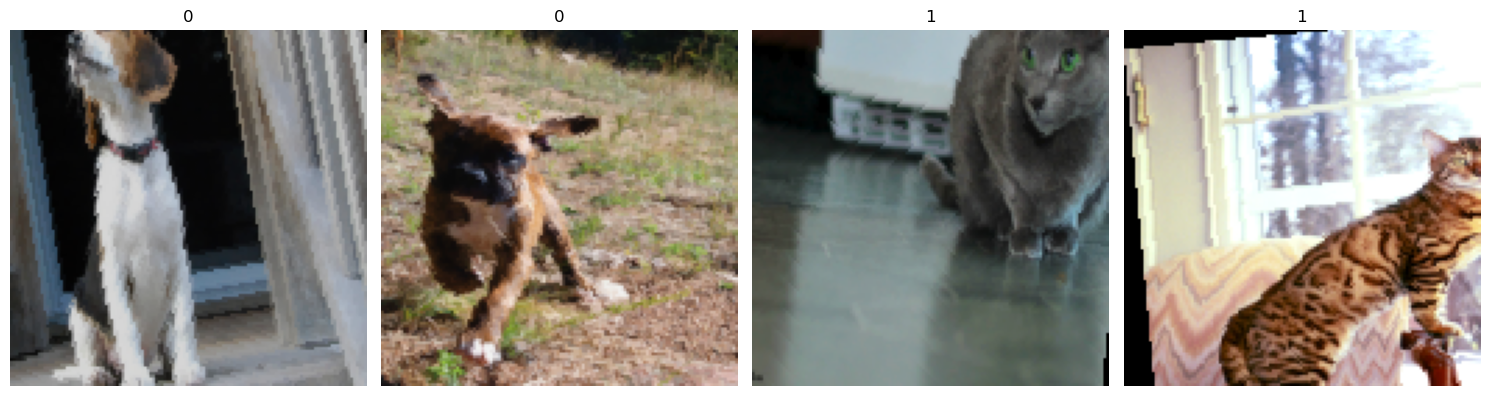

In [9]:
# Retrieve a single batch from the dataloader
batch = next(iter(train_loader))
# Display the batch of images
display_batch(batch)

In [10]:
# Instantiate the model
model = resnet18()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Selected device: {device}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'CUDA device count: {torch.cuda.device_count()}')
    print(f'CUDA device name: {torch.cuda.get_device_name(0)}')
    print(f'Current CUDA device: {torch.cuda.current_device()}')

model = model.to(device)

# Verify model is on the correct device
print(f'\nModel is on device: {next(model.parameters()).device}')
print(model)

Selected device: cuda
CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce RTX 5070 Ti
Current CUDA device: 0

Model is on device: cuda:0
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

Now we can define loss, choose optimizer, scheduler and run training.

To verify GPU is being used during training:
- Run `nvidia-smi` in a terminal to monitor GPU usage
- Check that GPU memory increases during training
- Training should be significantly faster on GPU than CPU

In [11]:
# Quick test to verify GPU is working
import time

# Get a small batch for testing
test_images, test_labels = next(iter(train_loader))

print("Testing GPU vs CPU performance...")
print(f"Batch shape: {test_images.shape}")

# Test on device (should be GPU if available)
test_images_device = test_images.to(device)
test_labels_device = test_labels.to(device)

start = time.time()
with torch.no_grad():
    output = model(test_images_device)
torch.cuda.synchronize() if torch.cuda.is_available() else None
device_time = time.time() - start

print(f"\nForward pass on {device}: {device_time:.4f} seconds")
print(f"Output device: {output.device}")
print(f"Output shape: {output.shape}")

if torch.cuda.is_available():
    print(f"\nGPU Memory allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
    print(f"GPU Memory reserved: {torch.cuda.memory_reserved()/1024**2:.2f} MB")

Testing GPU vs CPU performance...
Batch shape: torch.Size([64, 3, 128, 128])

Forward pass on cuda: 0.2435 seconds
Output device: cuda:0
Output shape: torch.Size([64, 2])

GPU Memory allocated: 62.82 MB
GPU Memory reserved: 292.00 MB


In [12]:
# Training

# Define the loss function (Cross-Entropy Loss for classification tasks)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (AdamW optimizer with an initial learning rate)
optimizer = optim.AdamW(model.parameters(), lr=0.0001) # sgd, rmsprop, ...
# optimizer = optim.RMSprop(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Define a learning rate scheduler to decrease the learning rate by a factor of 0.98 each epoch
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

# Initialize lists to store training and validation losses and accuracies for analysis
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize the best validation loss to infinity for model saving purposes
best_val_loss = float('inf')

# Training loop for the specified number of epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode (enables dropout, batch normalization, etc.)
    running_loss = 0.0
    correct = 0
    total = 0

    # Use tqdm for a progress bar during training
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False, ascii=True)
    for images, labels in train_loader_tqdm:
        # Move images and labels to the specified device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients to prevent accumulation

        outputs = model(images)          # Forward pass: compute predicted outputs
        loss = criterion(outputs, labels)  # Compute the loss

        loss.backward()  # Backward pass: compute gradients
        # Clip gradients to prevent exploding gradients in deep networks
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()  # Update parameters based on gradients

        running_loss += loss.item()  # Accumulate the running loss

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)    # Get the index of the max log-probability
        total += labels.size(0)                      # Increment the total number of samples
        correct += (predicted == labels).sum().item()  # Increment correct predictions

        # Update the progress bar with the current loss
        train_loader_tqdm.set_postfix({'Loss': f'{loss.item():8.4f}'})

    # Calculate average loss and accuracy over the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)        # Append training loss for plotting
    train_accuracies.append(epoch_accuracy)  # Append training accuracy for plotting

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:8.4f}, Accuracy: {epoch_accuracy:6.2f}%')

    # Validation phase
    model.eval()  # Set the model to evaluation mode (disables dropout, batch normalization, etc.)
    val_loss = 0.0
    correct = 0
    total = 0

    # Use tqdm for a progress bar during validation
    validation_loader_tqdm = tqdm(validation_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False, ascii=True)
    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in validation_loader_tqdm:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)          # Forward pass: compute predicted outputs
            loss = criterion(outputs, labels)  # Compute the loss
            val_loss += loss.item()          # Accumulate validation loss

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
            total += labels.size(0)                    # Increment the total number of samples
            correct += (predicted == labels).sum().item()  # Increment correct predictions

            # Update the progress bar with the current loss
            validation_loader_tqdm.set_postfix({'Loss': f'{loss.item():8.4f}'})

    # Calculate average validation loss and accuracy over the epoch
    val_epoch_loss = val_loss / len(validation_loader)
    val_losses.append(val_epoch_loss)         # Append validation loss for plotting
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)       # Append validation accuracy for plotting

    print(f'Validation Loss: {val_epoch_loss:8.4f}, Accuracy: {val_accuracy:6.2f}%\n')

    # Save the model if validation loss has decreased (improved)
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), best_model_path)  # Save the model parameters
        print(f'Model saved with validation loss: {best_val_loss:8.4f}')

    # Update the learning rate using the scheduler
    scheduler.step()

    # Optionally, print the updated learning rate
    current_lr = scheduler.get_last_lr()[0]
    print(f'Learning rate adjusted to: {current_lr:.7f}')

Epoch 1/60, Training Loss:   0.6638, Accuracy:  60.09%


Validation Loss:   0.8286, Accuracy:  50.79%

Model saved with validation loss:   0.8286
Learning rate adjusted to: 0.0000980


Epoch 2/60, Training Loss:   0.6273, Accuracy:  64.17%


Validation Loss:   0.6108, Accuracy:  67.89%

Model saved with validation loss:   0.6108
Learning rate adjusted to: 0.0000960


Epoch 3/60, Training Loss:   0.6026, Accuracy:  67.57%


Validation Loss:   0.5818, Accuracy:  70.79%

Model saved with validation loss:   0.5818
Learning rate adjusted to: 0.0000941


Epoch 4/60, Training Loss:   0.5723, Accuracy:  70.12%


Validation Loss:   0.5364, Accuracy:  75.00%

Model saved with validation loss:   0.5364
Learning rate adjusted to: 0.0000922


Epoch 5/60, Training Loss:   0.5500, Accuracy:  71.82%


Validation Loss:   0.5638, Accuracy:  73.42%

Learning rate adjusted to: 0.0000904


Epoch 6/60, Training Loss:   0.5239, Accuracy:  73.85%


Validation Loss:   0.4991, Accuracy:  76.32%

Model saved with validation loss:   0.4991
Learning rate adjusted to: 0.0000886


Epoch 7/60, Training Loss:   0.5084, Accuracy:  75.09%


Validation Loss:   0.5423, Accuracy:  73.68%

Learning rate adjusted to: 0.0000868


Epoch 8/60, Training Loss:   0.4832, Accuracy:  76.76%


Validation Loss:   0.4273, Accuracy:  79.74%

Model saved with validation loss:   0.4273
Learning rate adjusted to: 0.0000851


Epoch 9/60, Training Loss:   0.4606, Accuracy:  78.12%


Validation Loss:   0.4612, Accuracy:  79.74%

Learning rate adjusted to: 0.0000834


Epoch 10/60, Training Loss:   0.4393, Accuracy:  79.09%


Validation Loss:   0.4230, Accuracy:  82.63%

Model saved with validation loss:   0.4230
Learning rate adjusted to: 0.0000817


Epoch 11/60, Training Loss:   0.4184, Accuracy:  80.84%


Validation Loss:   0.4176, Accuracy:  81.32%

Model saved with validation loss:   0.4176
Learning rate adjusted to: 0.0000801


Epoch 12/60, Training Loss:   0.3990, Accuracy:  81.57%


Validation Loss:   0.6693, Accuracy:  71.05%

Learning rate adjusted to: 0.0000785


Epoch 13/60, Training Loss:   0.3866, Accuracy:  82.62%


Validation Loss:   0.4135, Accuracy:  82.11%

Model saved with validation loss:   0.4135
Learning rate adjusted to: 0.0000769


Epoch 14/60, Training Loss:   0.3671, Accuracy:  83.69%


Validation Loss:   0.4203, Accuracy:  82.37%

Learning rate adjusted to: 0.0000754


Epoch 15/60, Training Loss:   0.3575, Accuracy:  83.89%


Validation Loss:   0.3905, Accuracy:  81.84%

Model saved with validation loss:   0.3905
Learning rate adjusted to: 0.0000739


Epoch 16/60, Training Loss:   0.3277, Accuracy:  85.77%


Validation Loss:   0.3637, Accuracy:  82.63%

Model saved with validation loss:   0.3637
Learning rate adjusted to: 0.0000724


Epoch 17/60, Training Loss:   0.3250, Accuracy:  85.86%


Validation Loss:   0.3918, Accuracy:  81.05%

Learning rate adjusted to: 0.0000709


Epoch 18/60, Training Loss:   0.3157, Accuracy:  86.55%


Validation Loss:   0.3371, Accuracy:  85.79%

Model saved with validation loss:   0.3371
Learning rate adjusted to: 0.0000695


Epoch 19/60, Training Loss:   0.2993, Accuracy:  86.72%


Validation Loss:   0.4215, Accuracy:  81.32%

Learning rate adjusted to: 0.0000681


Epoch 20/60, Training Loss:   0.2899, Accuracy:  87.54%


Validation Loss:   0.4977, Accuracy:  82.11%

Learning rate adjusted to: 0.0000668


Epoch 21/60, Training Loss:   0.2835, Accuracy:  87.98%


Validation Loss:   0.3271, Accuracy:  85.79%

Model saved with validation loss:   0.3271
Learning rate adjusted to: 0.0000654


Epoch 22/60, Training Loss:   0.2717, Accuracy:  88.33%


Validation Loss:   0.3997, Accuracy:  85.26%

Learning rate adjusted to: 0.0000641


Epoch 23/60, Training Loss:   0.2598, Accuracy:  88.83%


Validation Loss:   0.3587, Accuracy:  85.26%

Learning rate adjusted to: 0.0000628


Epoch 24/60, Training Loss:   0.2573, Accuracy:  89.28%


Validation Loss:   0.2848, Accuracy:  88.68%

Model saved with validation loss:   0.2848
Learning rate adjusted to: 0.0000616


Epoch 25/60, Training Loss:   0.2360, Accuracy:  90.13%


Validation Loss:   0.3795, Accuracy:  85.79%

Learning rate adjusted to: 0.0000603


Epoch 26/60, Training Loss:   0.2396, Accuracy:  90.05%


Validation Loss:   0.3293, Accuracy:  85.53%

Learning rate adjusted to: 0.0000591


Epoch 27/60, Training Loss:   0.2273, Accuracy:  90.49%


Validation Loss:   0.2878, Accuracy:  87.89%

Learning rate adjusted to: 0.0000580


Epoch 28/60, Training Loss:   0.2259, Accuracy:  90.77%


Validation Loss:   0.3881, Accuracy:  83.95%

Learning rate adjusted to: 0.0000568


Epoch 29/60, Training Loss:   0.2177, Accuracy:  90.96%


Validation Loss:   0.3321, Accuracy:  87.37%

Learning rate adjusted to: 0.0000557


Epoch 30/60, Training Loss:   0.2164, Accuracy:  91.25%


Validation Loss:   0.2480, Accuracy:  89.74%

Model saved with validation loss:   0.2480
Learning rate adjusted to: 0.0000545


Epoch 31/60, Training Loss:   0.1980, Accuracy:  91.73%


Validation Loss:   0.2924, Accuracy:  90.53%

Learning rate adjusted to: 0.0000535


Epoch 32/60, Training Loss:   0.1923, Accuracy:  92.33%


Validation Loss:   0.3196, Accuracy:  88.16%

Learning rate adjusted to: 0.0000524


Epoch 33/60, Training Loss:   0.1943, Accuracy:  92.09%


Validation Loss:   0.2791, Accuracy:  88.42%

Learning rate adjusted to: 0.0000513


Epoch 34/60, Training Loss:   0.1784, Accuracy:  93.07%


Validation Loss:   0.2306, Accuracy:  89.47%

Model saved with validation loss:   0.2306
Learning rate adjusted to: 0.0000503


Epoch 35/60, Training Loss:   0.1810, Accuracy:  92.52%


Validation Loss:   0.3318, Accuracy:  88.68%

Learning rate adjusted to: 0.0000493


Epoch 36/60, Training Loss:   0.1814, Accuracy:  92.70%


Validation Loss:   0.2538, Accuracy:  88.95%

Learning rate adjusted to: 0.0000483


Epoch 37/60, Training Loss:   0.1686, Accuracy:  93.20%


Validation Loss:   0.3066, Accuracy:  87.89%

Learning rate adjusted to: 0.0000474


Epoch 38/60, Training Loss:   0.1728, Accuracy:  92.92%


Validation Loss:   0.2653, Accuracy:  88.68%

Learning rate adjusted to: 0.0000464


Epoch 39/60, Training Loss:   0.1669, Accuracy:  93.14%


Validation Loss:   0.4781, Accuracy:  85.26%

Learning rate adjusted to: 0.0000455


Epoch 40/60, Training Loss:   0.1643, Accuracy:  93.29%


Validation Loss:   0.2216, Accuracy:  89.47%

Model saved with validation loss:   0.2216
Learning rate adjusted to: 0.0000446


Epoch 41/60, Training Loss:   0.1514, Accuracy:  94.05%


Validation Loss:   0.3436, Accuracy:  88.16%

Learning rate adjusted to: 0.0000437


Epoch 42/60, Training Loss:   0.1617, Accuracy:  93.34%


Validation Loss:   0.2664, Accuracy:  87.89%

Learning rate adjusted to: 0.0000428


Epoch 43/60, Training Loss:   0.1489, Accuracy:  94.09%


Validation Loss:   0.3730, Accuracy:  86.58%

Learning rate adjusted to: 0.0000419


Epoch 44/60, Training Loss:   0.1518, Accuracy:  93.85%


Validation Loss:   0.3142, Accuracy:  88.16%

Learning rate adjusted to: 0.0000411


Epoch 45/60, Training Loss:   0.1518, Accuracy:  93.82%


Validation Loss:   0.2489, Accuracy:  90.26%

Learning rate adjusted to: 0.0000403


Epoch 46/60, Training Loss:   0.1369, Accuracy:  94.82%


Validation Loss:   0.2587, Accuracy:  89.74%

Learning rate adjusted to: 0.0000395


Epoch 47/60, Training Loss:   0.1424, Accuracy:  94.40%


Validation Loss:   0.2463, Accuracy:  90.53%

Learning rate adjusted to: 0.0000387


Epoch 48/60, Training Loss:   0.1379, Accuracy:  94.42%


Validation Loss:   0.2692, Accuracy:  88.68%

Learning rate adjusted to: 0.0000379


Epoch 49/60, Training Loss:   0.1257, Accuracy:  95.15%


Validation Loss:   0.2865, Accuracy:  88.42%

Learning rate adjusted to: 0.0000372


Epoch 50/60, Training Loss:   0.1290, Accuracy:  94.94%


Validation Loss:   0.2421, Accuracy:  91.05%

Learning rate adjusted to: 0.0000364


Epoch 51/60, Training Loss:   0.1246, Accuracy:  94.92%


Validation Loss:   0.3183, Accuracy:  87.89%

Learning rate adjusted to: 0.0000357


Epoch 52/60, Training Loss:   0.1298, Accuracy:  94.77%


Validation Loss:   0.3160, Accuracy:  89.47%

Learning rate adjusted to: 0.0000350


Epoch 53/60, Training Loss:   0.1232, Accuracy:  95.06%


Validation Loss:   0.3782, Accuracy:  87.89%

Learning rate adjusted to: 0.0000343


Epoch 54/60, Training Loss:   0.1170, Accuracy:  95.21%


Validation Loss:   0.2563, Accuracy:  89.47%

Learning rate adjusted to: 0.0000336


Epoch 55/60, Training Loss:   0.1164, Accuracy:  95.48%


Validation Loss:   0.4274, Accuracy:  87.11%

Learning rate adjusted to: 0.0000329


Epoch 56/60, Training Loss:   0.1150, Accuracy:  95.51%


Validation Loss:   0.4842, Accuracy:  85.26%

Learning rate adjusted to: 0.0000323


Epoch 57/60, Training Loss:   0.1182, Accuracy:  95.37%


Validation Loss:   0.2796, Accuracy:  89.21%

Learning rate adjusted to: 0.0000316


Epoch 58/60, Training Loss:   0.1127, Accuracy:  95.61%


Validation Loss:   0.3090, Accuracy:  89.21%

Learning rate adjusted to: 0.0000310


Epoch 59/60, Training Loss:   0.1150, Accuracy:  95.58%


Validation Loss:   0.2726, Accuracy:  88.95%

Learning rate adjusted to: 0.0000304


Epoch 60/60, Training Loss:   0.1121, Accuracy:  95.70%


Validation Loss:   0.2844, Accuracy:  88.95%

Learning rate adjusted to: 0.0000298


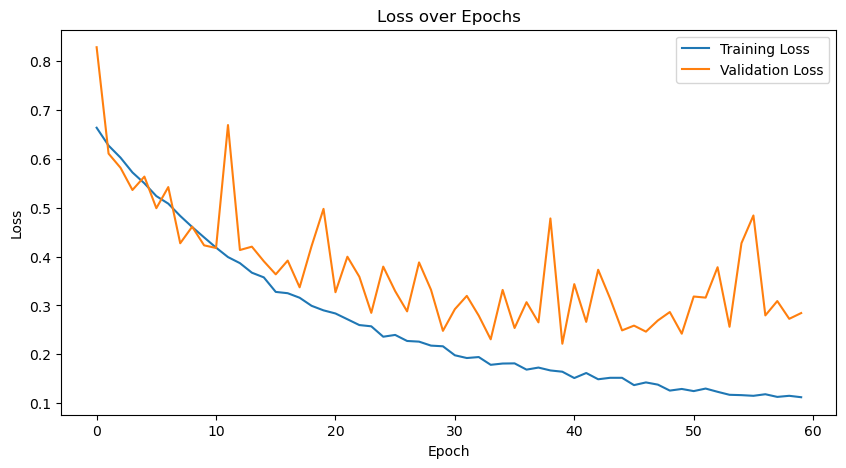

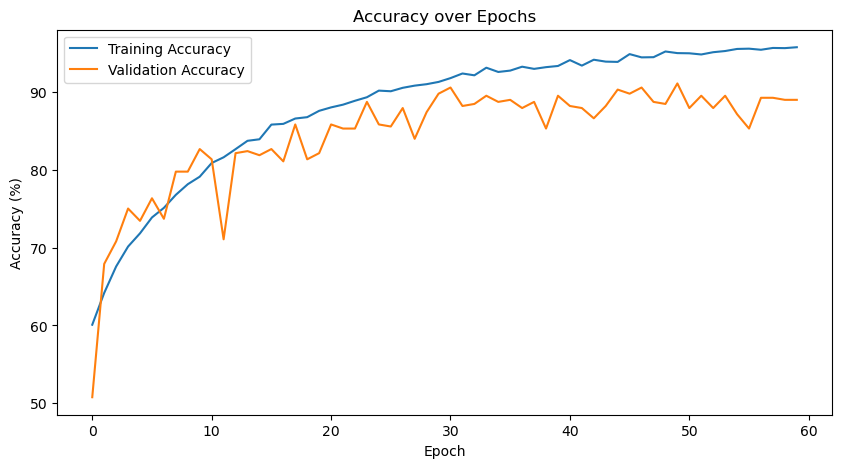

In [13]:
# Plotting Losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [14]:
# Load the best model
if os.path.exists(best_model_path):
    print(f"Loading model from {best_model_path}")
    model.load_state_dict(torch.load(best_model_path))

Loading model from best_model.pth


In [15]:
# Set the model to evaluation mode (disable dropout, batch normalization, etc.)
model.eval()

# Initialize variables to track the test loss, correct predictions, and total samples
test_loss = 0.0
correct = 0
total = 0

# Initialize a list to store wrong predictions for visualization later
wrong_predictions = []

# Use the tqdm progress bar for the test set
test_loader_tqdm = tqdm(test_loader, desc="[Testing]", leave=False, ascii=True)
with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader_tqdm:
        images, labels = images.to(device), labels.to(device)

        # Forward pass: compute predicted outputs
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get the predicted labels by selecting the class with the highest score
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)  # Update the total number of samples
        correct += (predicted == labels).sum().item()  # Increment correct predictions

        # Collect wrong predictions for visualization
        for img, pred, true_label in zip(images, predicted, labels):
            if pred != true_label:  # If prediction is wrong
                wrong_predictions.append((img.cpu(), pred.cpu(), true_label.cpu()))

# Calculate average test loss and accuracy
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.2291, Accuracy: 90.98%


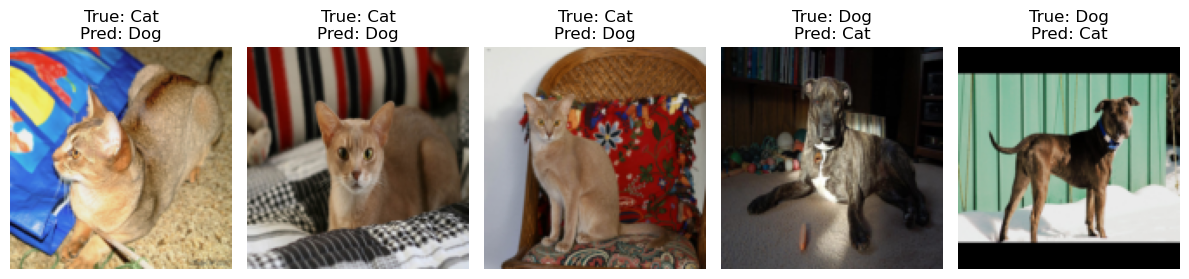

In [16]:
# Function to display images, predictions, and true labels
def show_wrong_predictions(wrong_predictions, class_names, num_images=5):
    plt.figure(figsize=(12, 6))
    
    # Display a few wrong predictions
    for i, (img, pred, true_label) in enumerate(wrong_predictions[:num_images]):
        img = denormalize(img) # Denormalize for display
        img = img.permute(1, 2, 0)  # Change the shape from [C, H, W] to [H, W, C] for visualization
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img.numpy())
        plt.title(f'True: {class_names[true_label]}\nPred: {class_names[pred]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# `class_names` maps class indices to class names
class_names = ['Dog', 'Cat']
show_wrong_predictions(wrong_predictions, class_names, num_images=5)  # Visualize 5 wrong predictions